###  Example on Dhamala's auto-regressive model

In this notebook we use the autoregressive example model from [Dhamala et. al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.018701). The model consists of two coupled random variables ($2\rightarrow 1$), the coupling is time-varying therefore the coherence should detect the coupling dynamics. The model is given by the equations bellow:

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index,
such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that
$X_2(t)$ influences $X_1(t)$ through the coupling constant $C$
(although the opposite does not happen). In the simulation $C(t)=0.25$ for $t<15$ s, and zero otherwise. 

In [1]:
import itertools
import os
import time

import h5py
import jax
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from frites.conn import conn_io
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_model_nd_cd, gcmi_nd_cc, mi_nd_gg
from frites.core.gcmi_1d import gcmi_1d_cc
from frites.io import check_attrs, logger, set_log_level
from frites.utils import parallel_func
from hoi.core import get_mi
from mne.filter import filter_data
from mne.time_frequency import tfr_array_morlet
from tqdm import tqdm

from plot import circular_hist

#### Defining function to simulate de model

In [71]:
def ar_model_dhamala(
    N=5000, Trials=10, Fs=200, C=0.2, tau=1, t_start=0, t_stop=None, cov=None
):
    """
    AR model from Dhamala et. al.
    """

    T = N / Fs

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N])
    Y = np.random.random([Trials, N])

    def interval(t, t_start, t_stop):
        if t_stop == None:
            return t >= t_start
        else:
            return (t >= t_start) * (t <= t_stop)

    for i in tqdm(range(Trials)):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N):
            X[i, t] = (
                0.55 * X[i, t - 1]
                - 0.8 * X[i, t - 2]
                + interval(time[t], t_start, t_stop) * C * Y[i, t - tau]
                #+ np.logical_not(interval(time[t], t_start, t_stop)) * C * Y[i, t - 1]
                + 0.25 * Y[i, t - tau]
                + E[t, 0]
            )
            Y[i, t] = 0.55 * Y[i, t - 1] - 0.8 * Y[i, t - 2] + E[t, 1]

    Z = np.zeros([Trials, 2, N])

    Z[:, 0, :] = X
    Z[:, 1, :] = Y

    return Z

Model parameters

In [72]:
N = 5000  # Number of observations
Fs = 200  # Sampling frequency
dt = 1.0 / Fs  # Time resolution
Trials = 100  # Number of trials
freqs = np.arange(1, 100, 1)  # Frequency axis
# Covariance matrix
cov = np.array([[1.00, 0.00], [0.00, 1.00]])

In [97]:
# Generating data
X = ar_model_dhamala(
    N=N, Trials=Trials, C=0.20, tau=1, Fs=Fs, t_start=10, t_stop=15, cov=cov
)
Y = ar_model_dhamala(
    N=N, Trials=Trials, C=0.50, tau=1, Fs=Fs, t_start=10, t_stop=15, cov=cov
)
Z = ar_model_dhamala(
    N=N, Trials=Trials, C=0.70, tau=1, Fs=Fs, t_start=10, t_stop=15, cov=cov
)
W = ar_model_dhamala(
    N=N, Trials=Trials, C=0.90, tau=1, Fs=Fs, t_start=10, t_stop=15, cov=cov
)

100%|██████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.48it/s]


In [98]:
X = np.concatenate((X, Y, Z, W), axis=0)

In [99]:
X = xr.DataArray(
    X,
    dims=("trials", "roi", "times"),
    coords={"times": np.arange(N) / Fs},
)

X.attrs["fsample"] = Fs

### Measuring stimulus-specific information

In [100]:
freqs = np.linspace(0.1, 80, 50)

W = tfr_array_morlet(
    X.values,
    Fs,
    freqs,
    freqs / 2,
    output="complex",
    n_jobs=10,
    zero_mean=False,
    decim=10,
)

W = xr.DataArray(
    W,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": X.times.values[::10]},
)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    2.4s finished


In [101]:
power_amplitude = np.abs(W)
complex_phase = W / power_amplitude
complex_phase_diff = complex_phase.isel(roi=0) * np.conj(complex_phase.isel(roi=1))


power_edge = np.stack(
    (power_amplitude.isel(roi=0), power_amplitude.isel(roi=1)), axis=1
)
phase_edge = np.stack((complex_phase_diff.real, complex_phase_diff.imag), axis=1)

power_phase_edge = np.stack(
    (
        power_amplitude.isel(roi=0),
        power_amplitude.isel(roi=1),
        complex_phase_diff.real,
        complex_phase_diff.imag,
    ),
    axis=1,
)

In [102]:
stim = np.stack([1] * 100 + [2] * 100 + [3] * 100 + [4] * 100)

In [103]:
power_encoding = gcmi_model_nd_cd(power_edge, stim, mvaxis=1, traxis=0)
phase_encoding = gcmi_model_nd_cd(phase_edge, stim, mvaxis=1, traxis=0)
power_phase_encoding = gcmi_model_nd_cd(power_phase_edge, stim, mvaxis=1, traxis=0)

In [104]:
# Redundancy
red = np.minimum(phase_encoding, power_encoding)

# Uniques
unique_power = power_encoding - red
unique_phase = phase_encoding - red

# Synergy
syn = power_phase_encoding - unique_power - unique_phase - red

In [105]:
"""
power_encoding_surr = []
phase_encoding_surr = []

_stim = np.stack([1] * 100 + [2] * 100 + [3] * 100)

for i in tqdm(range(100)):
    np.random.shuffle(_stim)
    power_encoding_surr += [gcmi_model_nd_cd(power_edge, _stim, mvaxis=1, traxis=0)]
    phase_encoding_surr += [gcmi_model_nd_cd(phase_edge, _stim, mvaxis=1, traxis=0)]
""";

In [106]:
power_encoding = xr.DataArray(
    power_encoding,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="power encoding [bits]",
).squeeze()

phase_encoding = xr.DataArray(
    phase_encoding,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

unique_power = xr.DataArray(
    unique_power,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

unique_phase = xr.DataArray(
    unique_phase,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

syn = xr.DataArray(
    syn,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

red = xr.DataArray(
    red,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

Text(0.5, 1.0, 'Phase only')

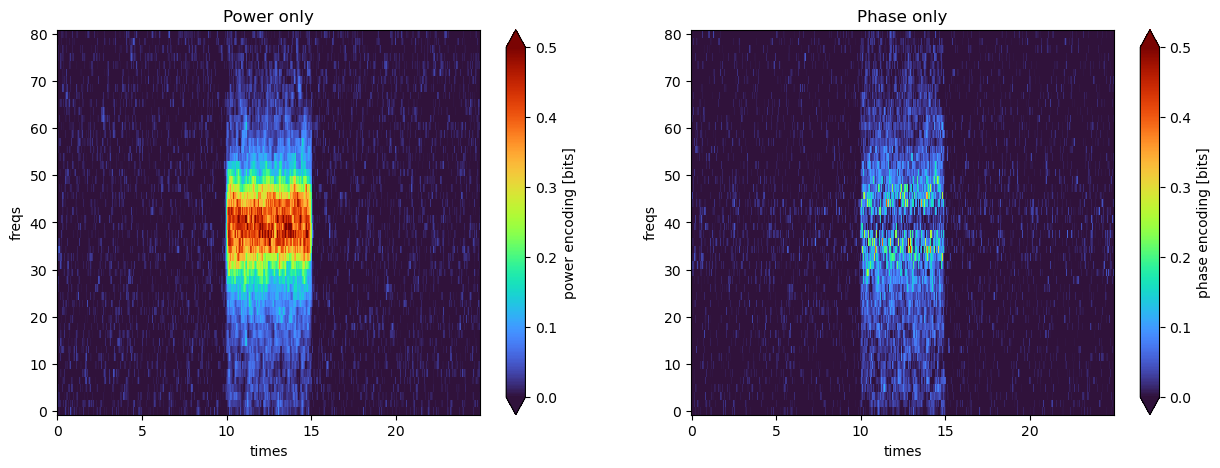

In [107]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
power_encoding.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Power only")
plt.subplot(122)
phase_encoding.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Phase only")

Text(0.5, 1.0, 'Synergy')

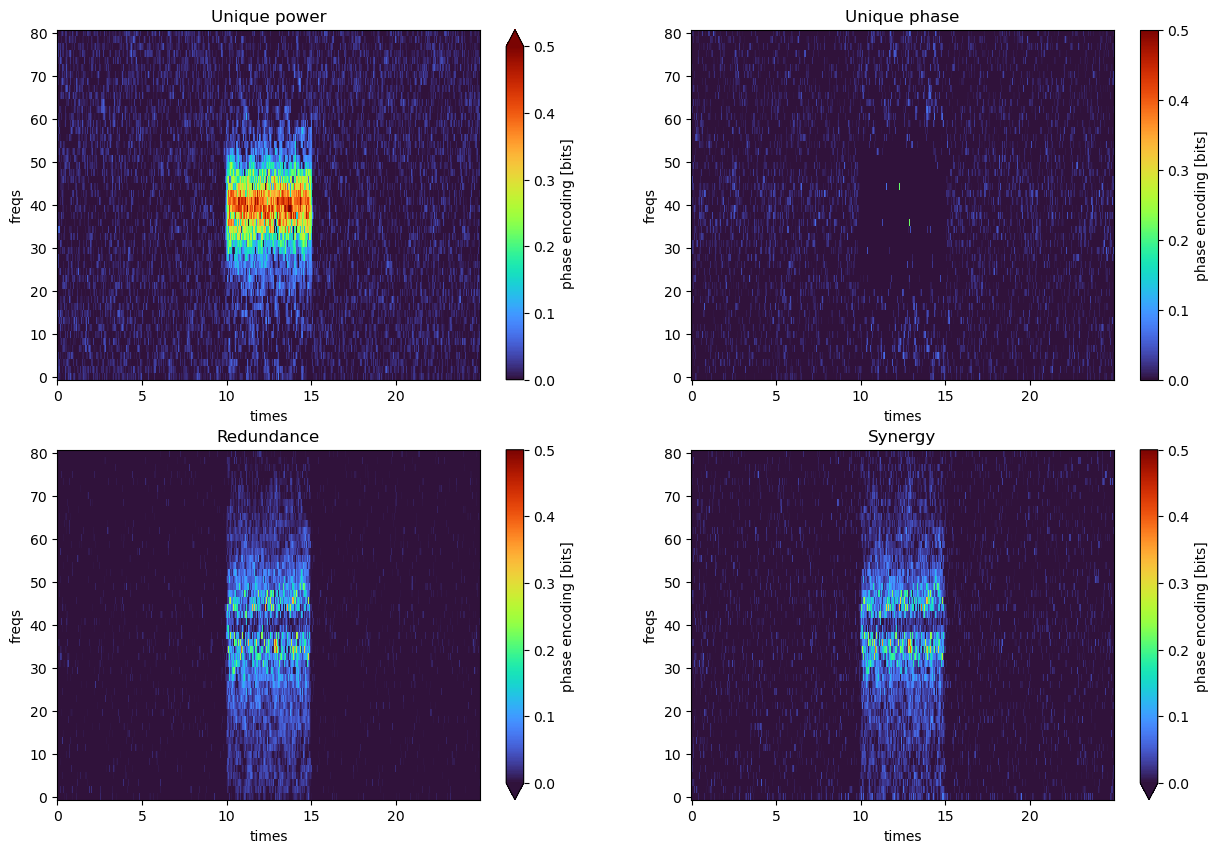

In [108]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
unique_power.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Unique power")
plt.subplot(222)
unique_phase.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Unique phase")
plt.subplot(223)
red.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Redundance")
plt.subplot(224)
syn.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Synergy")